# Проект E-commerce

Дашборд https://public.tableau.com/app/profile/stepan.bu/viz/Ecom_16814247311650/Dashboard1?publish=yes

Презентация
https://disk.yandex.ru/i/SEUWi2I0Ekn2ng

В рамках проекта для компании «Пока все ещё тут» мы планируем произвести выявление пользовательских профилей.
Наше исследование будет состоять их трех основных этапов:
- исследовательский анализ данных
- сегментация покупателей на основе истории их покупок
- формулировка и проверка гипотез

В предоставленном файле с данными есть следующие поля:

-  date  — дата заказа;
-  customer_id  — идентификатор покупателя;
-  order_id  — идентификатор заказа;
-  product  — наименование товара;
-  quantity  — количество товара в заказе;
-  price  — цена товара.
Исследование будет состоять из основных этапов:

### Предобработка данных
- приведение полей к необходимому формату
- проверка дубликатов
- проверка выбросов
### Исследовательский анализ данных
- выявление закономерностей в поведении пользователей
- построение графиков с распределением заказов, пользователей
- определение возможностей сегментации
### Сегментация покупателей на основе истории их покупок
- применим RFM анализ, для сегментации пользователей по сумме покупок
- сегментируем товары по категориям(возможно в зависимости от сезона)
### Формулировка и проверка гипотез
Возможные гипотезы:
- H0 - Нет различий между получившимся кластерами
- H1 - Есть различия между получившимся кластерами

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from pymystem3 import Mystem                                # для лемматизации
from collections import Counter

import seaborn as sns
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import math as mth
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
import scipy.stats as stats

### Предобработка данных
- Приведение полей к неободимому формату
- Проверка дубликатов
- Проверка выбросов

In [ ]:
# читаем файл
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/ecommerce_dataset.csv')
except:
    df = pd.read_csv('ecommerce_dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [ ]:
#приводим столбец с датой к корректному виду
df['date'] = pd.to_datetime(df['date'], format="%Y%m%d%H").dt.date

In [ ]:
# проверяем дубликаты по связке покупатель-заказ-товар-колво -цена
# повторений таких связок быть не должно, вероятнее всего это либо возвраты либо глюк в системе
df.duplicated(subset = ['customer_id','order_id', 'product', 'quantity', 'price']).sum()

1864

In [ ]:
df = df.drop_duplicates(subset = ['customer_id','order_id', 'product', 'quantity', 'price']).reset_index(drop=True)

In [ ]:
df.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Пропуски отсутствуют

In [ ]:
check_orders = df.groupby('order_id').agg({'customer_id':'nunique'}).reset_index()
check_orders = check_orders.query('customer_id > 1')
df_c = df[~df['order_id'].isin(check_orders['order_id'])]

In [ ]:
df_c

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
...,...,...,...,...,...,...
4868,2019-10-31,f17ed857-178e-45e1-a662-0a9dd3b58c5f,73155,Мимоза стыдливая d-9 см,1,329.0
4869,2019-10-31,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"Таз пластмассовый 40,0 л пищевой овальный (Иж)...",1,404.0
4870,2019-10-31,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0
4871,2019-10-31,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,Герань домашняя (пеларгония зональная) цветуща...,1,157.0


В df присутствуют заказы, сделанные несколькими пользователями - вероятнее всего это ошибка. Мы исключили такие заказы.

### Вывод
Данные загружены в переменную df , столбец с датой приведен к нужному виду
Дубликаты проверены
Пропуски проверены

### Исследовательский анализ данных
- выявление закономерностей в поведении пользователей
- построение графиков с распределением заказов, пользователей
- определение возможностей сегментации

In [ ]:
print('Исследуемый период : c {} по {}'.format(df['date'].min() , df['date'].max()))

Исследуемый период : c 2018-10-01 по 2019-10-31


In [ ]:
# создаем пременную revenue с выручкой
df['revenue'] = df['quantity'] * df['price']

Text(0.5, 0, 'Выручка')

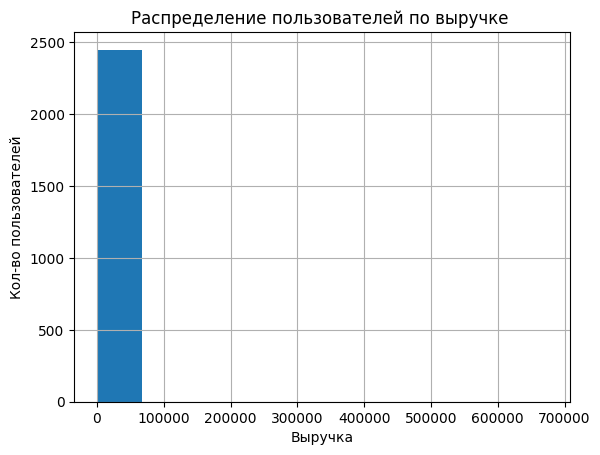

In [ ]:
df.groupby('customer_id').agg({'revenue':'sum'}).sort_values('revenue', ascending = False).hist()
plt.title("Распределение пользователей по выручке ")
plt.ylabel("Кол-во пользователей")
plt.xlabel("Выручка")

В столбце выручка присутствует большое кол-во выбросов. Их нужно будет убрать либо по цене, либо по кол-во

In [ ]:
print('В исходном df {} покупателей'.format(len(df['customer_id'].unique())))

В исходном df 2451 покупателей


In [ ]:
df['quantity'].describe()

count    4873.000000
mean        2.837472
std        17.606813
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

Text(0.5, 0, 'Кол-во в заказах')

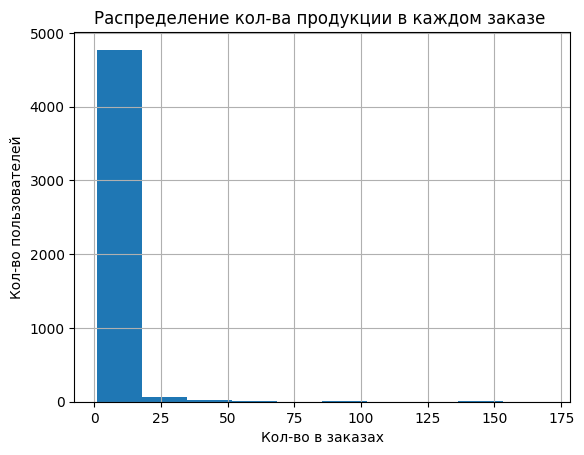

In [ ]:
df.query('quantity < 200')['quantity'].hist()
plt.title("Распределение кол-ва продукции в каждом заказе ")
plt.ylabel("Кол-во пользователей")
plt.xlabel("Кол-во в заказах")

In [ ]:
print('Было до очистки {}, стало после {} .Потери составили {} строки'.format(len(df) , len(df_c) , len(df) - len(df_c)))

Было до очистки 4873, стало после 4807 .Потери составили 66 строки


Text(0, 0.5, 'Выручка')

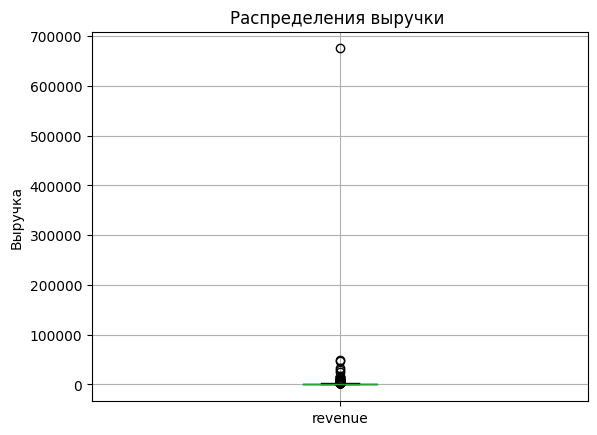

In [ ]:
check_revenue = df.groupby(['order_id','quantity','product','price']).agg({'revenue':'sum'}).reset_index().sort_values('revenue',ascending = False)
check_revenue.query('quantity != 1').boxplot('revenue')
check_revenue.query('quantity != 1').describe()

plt.title("Распределения выручки ")
plt.ylabel("Выручка")


In [ ]:
check_revenue

,order_id,quantity,product,price,revenue
4098,71743,1000,"Вантуз с деревянной ручкой d14 см красный, Bur...",675.0,675000.0
4061,71668,334,Вешалки мягкие для деликатных вещей 3 шт шоколад,148.0,49432.0
3104,69830,27,Простынь вафельная 200х180 см WELLNESS RW180-0...,1755.0,47385.0
2953,69504,57,Тележка багажная DELTA ТБР-22 синий грузоподъе...,574.0,32718.0
2743,69156,64,Набор ножей Attribute CHEF 5 предметов AKF522,457.0,29248.0
...,...,...,...,...,...
100,14512,1,"Огурец Засолочный 0,3 г 4660010776102",10.0,10.0
98,14512,1,Морковь Детская сладость 2 г 4660010775921,10.0,10.0
284,14559,1,"Горох Амброзия 10,0 г 4660010772616",9.0,9.0
114,14514,1,"Львиный зев Волшебный ковер 0,05 г 4660010779639",9.0,9.0


In [ ]:
df_c = df.query('order_id != 71743')

Заказ 71743 выглядит аномально большим и по выручке и по кол-ву. Исключаем только его

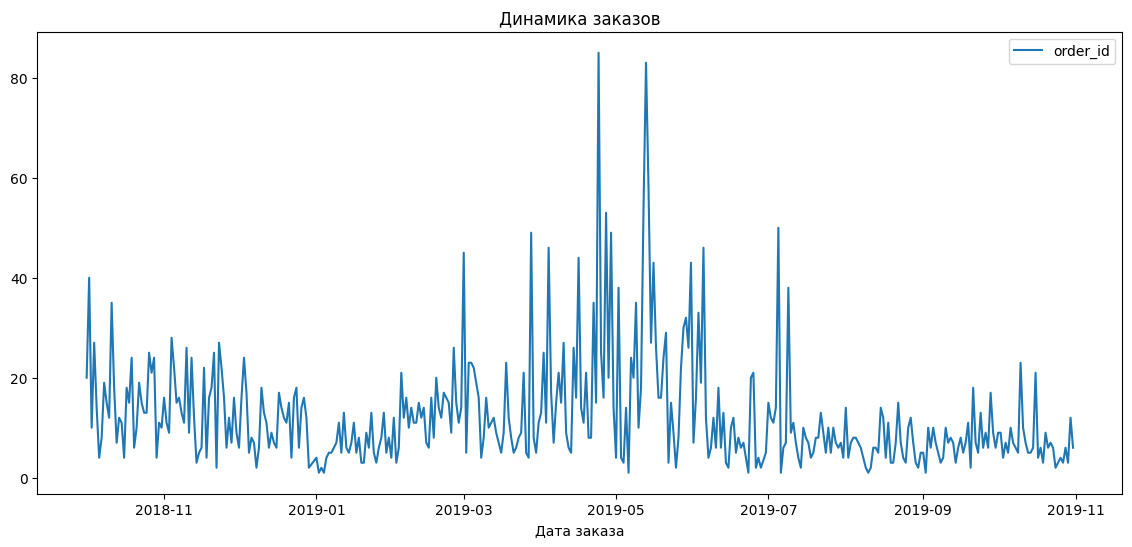

In [ ]:
df_c.groupby('date').agg({'order_id':'count'}).plot(figsize=(14, 6))
plt.title('Динамика заказов')
plt.xlabel('Дата заказа')
plt.show()

Можно говорить о всплеске заказов в период с мая 2019 - до июля 2019 - вероятнее всего есть сезонность в покупках

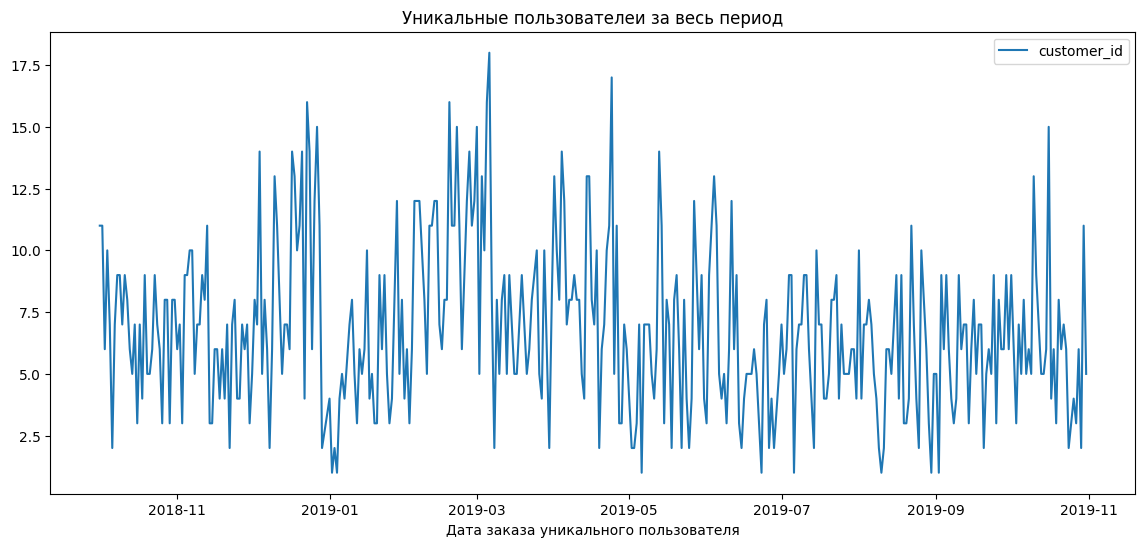

In [ ]:
df_c.groupby('date').agg({'customer_id':'nunique'}).plot(figsize=(14, 6))
plt.title('Уникальные пользователеи за весь период')
plt.xlabel('Дата заказа уникального пользователя')
plt.show()

На графике уникальных пользователей видно, что всплески активности происходят неравномерно. Больше всего пиков мы видим с Апреля 2019 - до Мая 2019

# Вывод
Исследуемый период : c 2018-10-01 по 2019-10-31.
Некоторые столбцы имели явные выбросы, которые мы ограничили:
- кол-во в одном заказе не более 200 шт
- цена< 99 процентиля (4951 у.е.)

Можно говорить о всплеске заказов в период с мая 2019 - до июля 2019 - вероятнее всего есть сезонность в покупках.
На графике уникальных пользователей видно, что всплески активности происходят неравномерно. Больше всего пиков мы видим с Апреля 2019 - до Мая 2019.

### Сегментация покупателей на основе истории их покупок
- Применим RFM анализ, для сегментации пользователей по сумме покупок
- Сегментируем товары по категориям(возможно в зависимости от сезона)


recency frequency monetary

- r (как давно что-то покупал? Чем более недавно, тем лучше) 1-4
- f (как часто покупал ранее? Чем чаще, тем лучше) 1-4
- m (как много денег потратил на нас? Чем больше, тем лучше) 1-4

In [ ]:
now = dt.datetime(2019,11,1)
df_c['date'] = pd.to_datetime(df_c['date'])

<ipython-input-22-82a49cfe2502>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['date'] = pd.to_datetime(df_c['date'])


In [ ]:
RFM_table=df_c.groupby('customer_id').agg({'date': lambda x: (now - x.max()).days, # Recency
                                                'order_id': lambda x: len(x.unique()), # Frequency
                                                'revenue': lambda x: x.sum()})    # Monetary

RFM_table['date'] = RFM_table['date'].astype(int)
RFM_table.rename(columns={'date': 'recency',
                         'order_id': 'frequency',
                         'revenue': 'monetary_value'}, inplace=True)

In [ ]:
quantiles = RFM_table.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,110.25,1.0,299.0
0.50,213.00,1.0,712.0
0.75,296.00,1.0,1574.0


In [ ]:
quantiles = quantiles.to_dict()
##  RFM Segmentation ----
RFM_Segment = RFM_table.copy()
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4
RFM_Segment['R_Quartile'] = RFM_Segment['recency'].apply(R_Class, args=('recency',quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency',quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['monetary_value'].apply(FM_Class, args=('monetary_value',quantiles,))
RFM_Segment['RFMClass'] = RFM_Segment.R_Quartile.map(str) \
                            + RFM_Segment.F_Quartile.map(str) \
                            + RFM_Segment.M_Quartile.map(str)

In [ ]:
RFM_Segment['mean_score'] = (RFM_Segment['R_Quartile'] + RFM_Segment['F_Quartile'] + RFM_Segment['M_Quartile']) / 3
RFM_Segment

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,mean_score
customer_id,,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,16,1,555.0,4,1,2,412,2.333333
001cee7f-0b29-4716-b202-0042213ab038,258,1,442.0,2,1,2,212,1.666667
00299f34-5385-4d13-9aea-c80b81658e1b,18,1,914.0,4,1,3,413,2.666667
002d4d3a-4a59-406b-86ec-c3314357e498,278,1,1649.0,2,1,4,214,2.333333
003bbd39-0000-41ff-b7f9-2ddaec152037,33,1,2324.0,4,1,4,414,3.000000
...,...,...,...,...,...,...,...,...
ff601403-b094-4b86-9ac6-264d725b9277,77,1,1649.0,4,1,4,414,3.000000
ffaeab76-3a8d-49ee-860f-17273b2fc8a2,2,1,397.0,4,1,2,412,2.333333
ffb5976a-7a4d-460b-95c4-5ffaba31cb24,322,1,389.0,1,1,2,112,1.333333


In [ ]:
# объединяем таблицы
ndf = df_c.merge(RFM_Segment , on ='customer_id' , how = 'inner')
ndf

,date,customer_id,order_id,product,quantity,price,revenue,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,mean_score
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,396,1,1037.0,1,1,3,113,1.666667
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,396,1,1037.0,1,1,3,113,1.666667
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,396,1,1037.0,1,1,3,113,1.666667
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,396,1,1037.0,1,1,3,113,1.666667
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,396,1,1037.0,1,1,3,113,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867,2019-10-30,b24b3075-bbb5-498c-add9-534a727f3c33,73151,Герань домашняя (пеларгония зональная) цветуща...,2,157.0,314.0,2,1,314.0,4,1,2,412,2.333333
4868,2019-10-31,6ddd4081-515e-401a-9567-8c0eab6dc868,73154,Литопс Микс d-5 см,1,112.0,112.0,1,1,112.0,4,1,1,411,2.000000
4869,2019-10-31,f17ed857-178e-45e1-a662-0a9dd3b58c5f,73155,Мимоза стыдливая d-9 см,1,329.0,329.0,1,1,329.0,4,1,2,412,2.333333
4870,2019-10-31,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0,1087.0,1,1,1087.0,4,1,3,413,2.666667


In [ ]:
# формируем датафрейм с необходимыми нам столбцами
ndf = ndf[['date','customer_id','order_id','product','quantity','price','revenue','RFMClass','mean_score']]
ndf

,date,customer_id,order_id,product,quantity,price,revenue,RFMClass,mean_score
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,113,1.666667
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,113,1.666667
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,113,1.666667
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,113,1.666667
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,113,1.666667
...,...,...,...,...,...,...,...,...,...
4867,2019-10-30,b24b3075-bbb5-498c-add9-534a727f3c33,73151,Герань домашняя (пеларгония зональная) цветуща...,2,157.0,314.0,412,2.333333
4868,2019-10-31,6ddd4081-515e-401a-9567-8c0eab6dc868,73154,Литопс Микс d-5 см,1,112.0,112.0,411,2.000000
4869,2019-10-31,f17ed857-178e-45e1-a662-0a9dd3b58c5f,73155,Мимоза стыдливая d-9 см,1,329.0,329.0,412,2.333333
4870,2019-10-31,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0,1087.0,413,2.666667


In [ ]:
#считаем кол-вл пользователей в каждом классе
count_by_class = ndf.groupby('RFMClass').agg({'customer_id':'nunique'}).sort_values('customer_id' , ascending = False).reset_index()
fig = px.bar(count_by_class, x='RFMClass', y='customer_id')
fig.update_traces(textposition='outside')
fig.update_layout(
    title='Итоговое распределение пользователей по RFM группам',
    xaxis_title="Группа",
    yaxis_title="Количество")

fig.show()



Больше всего пользователей относятся к группам  : 114 , 411 , 311,113
Меньше всего пользователей получилось в группах: 143 , 142, 341, 141

In [ ]:
rfm_revenue = ndf.groupby('RFMClass').agg({'revenue':'mean'}).reset_index()
fig = px.bar(rfm_revenue, x='RFMClass', y='revenue')
fig.update_traces(textposition='outside')
fig.update_layout(
    title='Распределение средней выручки по группам RFM',
    xaxis_title="Группа",
    yaxis_title="Средняя выручка")

fig.show()


На графике с распределением средней выручки заметно выделяются группы 114,144,214,244,414,444 - это подтверждает корректность нашего распределения по RFM сегментам.

In [ ]:
# чтобы сформировать 4 кластера пользователей - усреднили их очки по RFM score и округлили до целого
ndf['mean_score'] = round(ndf['mean_score'],0)

<ipython-input-31-f5acfa33beee>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
revenue_per_month = ndf.pivot_table(index=['date', 'mean_score'], values=['customer_id', 'revenue', 'order_id'], aggfunc={
    'customer_id':'nunique', 'revenue':'sum', 'order_id':'nunique'}).reset_index()
revenue_per_month

,date,mean_score,customer_id,order_id,revenue
0,2018-10-01,1.0,3,3,1071.0
1,2018-10-01,2.0,6,6,12002.0
2,2018-10-01,3.0,2,2,861.0
3,2018-10-02,1.0,4,4,1225.0
4,2018-10-02,2.0,4,4,8660.0
...,...,...,...,...,...
903,2019-10-30,3.0,5,5,4509.0
904,2019-10-30,4.0,1,2,1858.0
905,2019-10-31,2.0,3,3,598.0
906,2019-10-31,3.0,1,1,1087.0


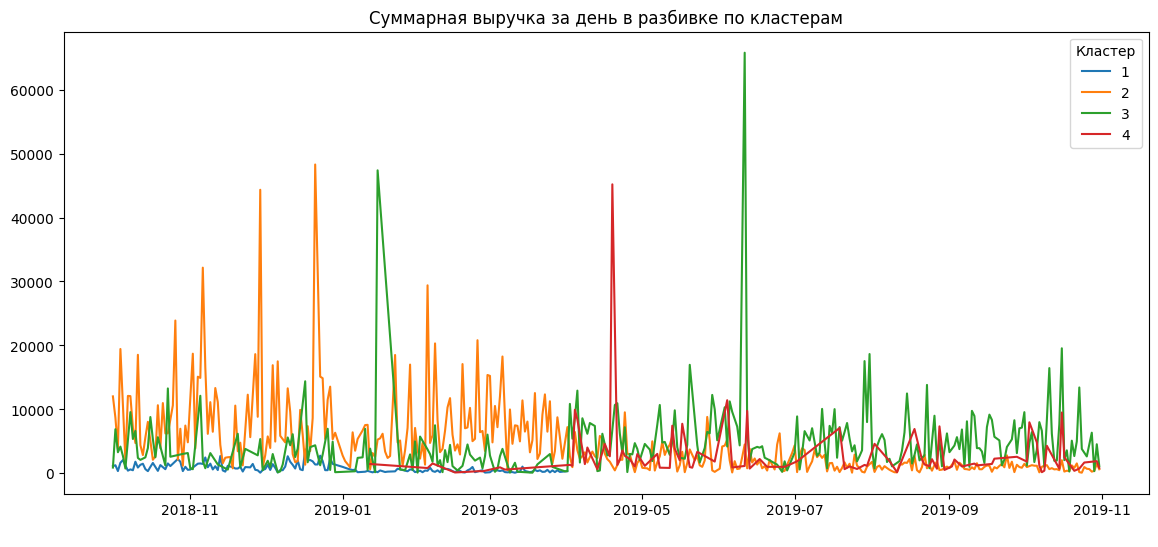

In [ ]:
# строим гафик с средней выручкой по каждому из 4 кластеров
plt.figure(figsize=(14, 6))
plt.plot(revenue_per_month[revenue_per_month['mean_score'] == 1]['date'], revenue_per_month[revenue_per_month['mean_score'] == 1]['revenue'], label='1')
plt.plot(revenue_per_month[revenue_per_month['mean_score'] == 2]['date'], revenue_per_month[revenue_per_month['mean_score'] == 2]['revenue'], label='2')
plt.plot(revenue_per_month[revenue_per_month['mean_score'] == 3]['date'], revenue_per_month[revenue_per_month['mean_score'] == 3]['revenue'], label='3')
plt.plot(revenue_per_month[revenue_per_month['mean_score'] == 4]['date'], revenue_per_month[revenue_per_month['mean_score'] == 4]['revenue'], label='4')
plt.title('Суммарная выручка за день в разбивке по кластерам')
plt.xlabel(' ')
plt.legend(title='Кластер')
plt.show()

Первый кластер показывает самые низкие показатели, а продаж с 04-2019 вообще нет
Остальные кластеры имеют частые выбросы, которых становится меньше после 05-2019 и до конца года.
Показатели всех трех кластеров показывают примерно похожие результаты, тем не менее 3 и 4 кластер заметно выделяются.

In [ ]:
# создаем переменные для куммулятивной выручки для каждого кластера
cummulative_rev_1 = revenue_per_month.query('mean_score == 1')
cummulative_rev_2 = revenue_per_month.query('mean_score == 2')
cummulative_rev_3 = revenue_per_month.query('mean_score == 3')
cummulative_rev_4 = revenue_per_month.query('mean_score == 4')

In [ ]:
# считаем куммулятивные значения
cummulative_rev_1['revenue'] = np.cumsum(cummulative_rev_1['revenue'])
cummulative_rev_2['revenue'] = np.cumsum(cummulative_rev_2['revenue'])
cummulative_rev_3['revenue'] = np.cumsum(cummulative_rev_3['revenue'])
cummulative_rev_4['revenue'] = np.cumsum(cummulative_rev_4['revenue'])

<ipython-input-35-fd4e7c82323e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-35-fd4e7c82323e>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-35-fd4e7c82323e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-35-fd4e7c8

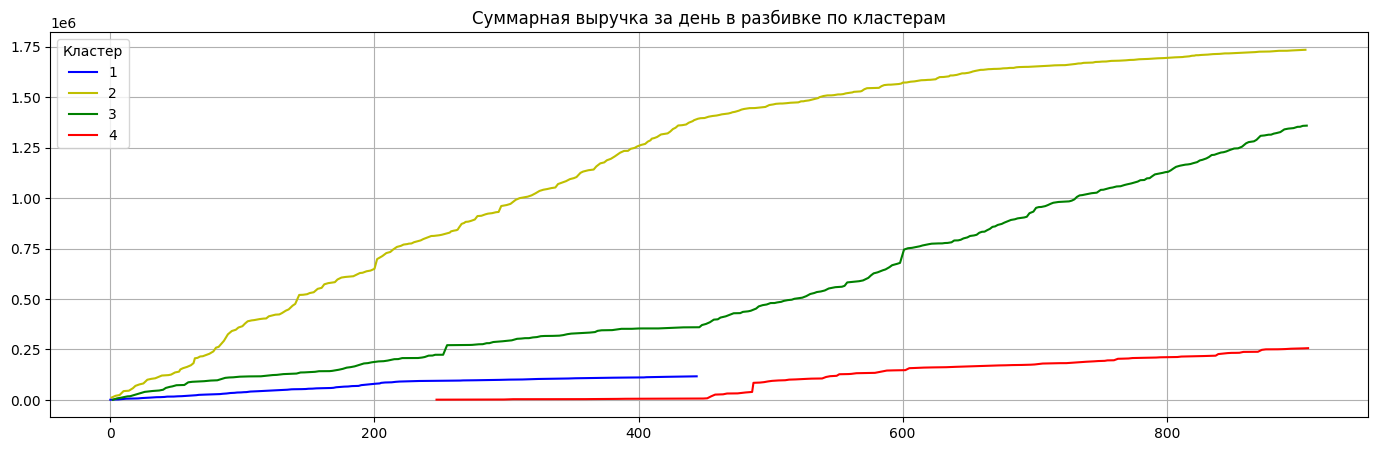

In [ ]:
plt.figure(figsize=(17, 5))
cummulative_rev_1['revenue'].plot(color='b', label=1)
cummulative_rev_2['revenue'].plot(color='y', label=2)
cummulative_rev_3['revenue'].plot(color='g', label=3)
cummulative_rev_4['revenue'].plot(color='r', label=4)
plt.title('Суммарная выручка за день в разбивке по кластерам')
plt.xlabel('')
plt.grid(True)
plt.legend(title='Кластер')
plt.show()

По куммулятивной выручке лидирует кластер 2 , за ним идет 3
Кластеры 1 имеет самый низкий показатель куммулятивной выручке

### Вывод
Для сегментации пользователей мы применили RFM анализ, который позволяет оценить: на сколько давно пользователь совершил покупку? как часто покупал до этого? как много потратил пользователь?
Анализ позволил сегментировать пользователей на группы, в зависимости от их ценности. Чем больше число - тем ценнее пользователь.
Больше всего пользователей по итогам RFM анализа относятся к группам  : 114 , 411 , 311,113
Меньше всего пользователей получилось в группах: 143 , 142, 341, 141.
На графике с распределением средней выручки заметно выделяются группы 114,144,214,244,414,444 - это подтверждает корректность нашего распределения по RFM сегментам.
Первый кластер показывает самые низкие показатели, а продаж с 04-2019 вообще нет
Остальные кластеры имеют частые выбросы, которых становится меньше после 05-2019 и до конца года.
Показатели всех трех кластеров показывают примерно похожие результаты, тем не менее 3 и 4 кастер заметно выделяются.
По куммулятивной выручке лидирует кластер 2 , за ним идет 3
Кластеры 1 имеет самый низкий показатель куммулятивной выручке

## Сегментация товаров
Для сегментации товаров будем использовать леммизацию наименований и поиск ключевых слов, чтобы отнести их к той или иной категории

In [ ]:
ndf[ndf['product'].isna()]

,date,customer_id,order_id,product,quantity,price,revenue,RFMClass,mean_score


In [ ]:
m = Mystem()
product_unique = ndf['product'].unique()
lemmas = []
for i in product_unique:
    result = ''.join(m.lemmatize(i)).strip()
    lemmas.append(result)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
text = m.lemmatize(' '.join(lemmas))
Counter(text)

Counter({'комнатный': 26,
         ' ': 17707,
         'растение': 31,
         'в': 274,
         'горшок': 130,
         'алый': 3,
         'вера': 2,
         ', ': 1066,
         'd12': 3,
         'h30': 6,
         'кофе': 6,
         'арабика': 5,
         'h25': 1,
         'радермахер': 1,
         'd': 252,
         '-': 980,
         '12': 148,
         'см': 1062,
         'h': 61,
         '20': 73,
         'хризолидокарпус': 1,
         'лутесценс': 1,
         '9': 123,
         'циперус': 1,
         'зумул': 1,
         '25': 44,
         'шеффлер': 2,
         'лузеан': 1,
         'юкка': 1,
         'нитчатый': 1,
         '35': 8,
         'настенный': 30,
         'сушилка': 120,
         'для': 547,
         'белье': 144,
         'Gimi': 61,
         'Brio': 4,
         'Super': 7,
         '100': 58,
         'таз': 35,
         'пластмассовый': 59,
         '21': 20,
         ',': 295,
         '0': 164,
         'л': 253,
         'круглый': 23,
         '

In [ ]:
product_lem = []
for i in ndf['product']:
    result = ''.join(m.lemmatize(i)).strip()
    product_lem.append(result)
ndf['product_lem'] = product_lem

<ipython-input-40-0fa6d50a5b4f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# заводим функцию для категоризации товаров
def get_categ_from_lem(product_lem):
    for i in kitchen:
        if i  in product_lem:
            return 'Кухня'
    for i in house:
        if i in product_lem:
            return 'Товары для дома'
    for i in countryside:
        if i in product_lem:
            return 'Загородный отдых'
    for i in construction:
        if i in product_lem:
            return 'Строительство'
    for i in plants:
        if i in product_lem:
            return 'Растения'
    return 'error'

In [ ]:
# формируем словари для разделения категорий
plants = ['d-', 'd-5', 'd-7', 'd-9', 'd10', 'd-10', 'd-11', 'D12', 'D12,', 'd12', 'd-12', 'd-13', 'd-14', 'd-15',
                  'd-17', 'd-18', 'd-19', 'd-20', 'd-21', 'D23', 'd-23','ель','бегония', 'клубника','фуксия', 'гипсофил',
            'вербейник','лен','арбуз', 'лобелия', 'антуриум', 'бадан','гайлардий','бузульник','петуния',
            'дендробиум','томат','колокольчик', 'монарда', 'осина',  'рассада','кипарисовик','лилейник','роза','георгин', 'календула', 'хризантема', 'кореопсис',]

countryside = ['урна', 'почтовый', 'девичий', 'настурция', 'лапчатка', 'цинния', 'многолетний',   'черенок', 'косметь', 'дыня', 'гортензия', 'тележка', 'нивянник', 'веревка',
         'седум', 'кашпо',  'анемон', 'хозяйственный', 'кассета', 'сумка-тележка', 'урна-пепельница', 'алиссум',
         'физостегия', 'энотера', 'фал', 'астра', 'мусорный', 'пеларгония', 'клен', 'автополив', 'тюльпан',
         'флокс', 'колосковый', 'камнеломка', 'садовый', 'аквилегия', 'папоротник', 'виола', 'пикник', 'платикодон',
         'рудбекия', 'хоста', 'эхинацея', 'котовник', 'пьезозажигалка',
         'уличный', 'зола',  'шнур', 'ясколка', 'веник', 'мусор', 'ранункулус',
           'солидаго', 'бакоп',  'калибрахоа',
          'пиретрум', 'бензин', 'гвоздик', 'шпагат', 'барвинок', 'г', 'щетка-сметка', 'вербена',
          'корыто']

house = ['стирка', 'тряпкодержатель', 'коробка', 'полировка', 'мыло-скраб', 'коврик', 'прищепок', 'крючок',
                   'мыло', 'совок', 'унитазный', 'плед', 'кондиционер', 'вантуз', 'пыль', 'наматрацник', 'зубной',
                   'увлажнять', 'муляж', 'засор', 'вешалка-плечики', 'сушилка', 'штора', 'весы', 'ткань', 'известковый',
                   'стиральный', 'унитаз', 'подрукавник', 'шило', 'ванна', 'туалетный', 'щетка', 'гладильный', 'чехол',
                   'полимербыт', 'ванная', 'утюг', 'искусственный', 'скребок', 'полотенце', 'насадка-моп', 'ковер', 'пол',
                   'подголовник', 'кофр', 'калла', 'одеяло', 'пододеяльник', 'простыня', 'ролик', 'хранение', 'перчатка',
                   'вешалка', 'салфетка', 'наволочка', 'пятно', 'корзина', 'фен', 'постельный', 'вешалка-перекладина', 'лавр',
                   'ковш', 'вещь', 'ведро', 'щетка-утюжок', 'ваза', 'окномойка', 'насадка', 'ванный', 'отбеливатель',
                   'радиаторный', 'тряпка', 'вешалка-стойка', 'покрывало', 'наматрасник', 'глажение', 'искуственный', 'туалет'
                   , 'лоток', 'фоторамка', 'плечики', 'сантехника', 'подушка', 'цикламен,', 'наматрицник-чехол',
                   'светильник', 'таз', 'вешалка-сушилка', 'швабра', 'бак', 'халат', 'комнатный', 'ключница']

kitchen = ['бокал', 'салатник', 'пресс', 'салфетница', 'бульонница', 'венчик', 'бидон', 'нож', 'сотейник',
                 'соковыжималка', 'терка', 'измельчитель', 'сито', 'столовый', 'соковарка', 'чайный', 'антижир',
                 'лопатка', 'кондитерский', 'блюдо', 'ножеточка', 'скалка', 'мантоварка', 'вилка', 'кружка', 'сахарница',
                 'тарелка', 'продукт', 'картофелемялка', 'скатерть', 'сковорода', 'кухонный', 'термостакан', 'противень',
                 'овощечистка', 'кастрюля', 'плита', 'термокружок', 'кекс', 'миска', 'половник', 'стакан', 'герметичный',
                 'овсянница', 'бутылка', 'тортница', 'отделитель', 'миксер', 'мини-сковорода', 'термос', 'хлебница',
                 'выпечка', 'мантоварка-пароварка', 'кипятильник', 'чайник', 'разделочный', 'яйцо', 'электроштопор',
                 'посуда', 'банка', 'мука', 'бутылочный', 'толкушка', 'орехоколка', 'посудомоечный', 'блюдце', 'фужер',
                 'рыбочистка', 'овощеварка', 'свч', 'крышка', 'ложка', 'губка']

construction = ['линейка', 'стремянка-табурет', 'этажерка', 'крепеж', 'угольник,', 'стремянка', 'строительный', 'форточный',
             'шпингалет', 'комод', 'карниз', 'фиксатор-шар', 'угольник', 'полк', 'подставка', 'пробка', 'инструмент', 'пуф',
             'обувница-3', 'сверло', 'полка', 'свереть', 'сверло-фреза,', 'напильник', 'штангенциркуль', 'уголок', 'стеллаж',
             'вентиляционный', 'болт', 'линейка,', 'сварка', 'петля-стрела', 'петля', 'мебельный', 'лестница-стремянка','ручка-скоба']


In [ ]:
ndf['category'] = ndf['product_lem'].apply(get_categ_from_lem)
ndf = ndf.drop('product_lem', axis=1)
ndf


<ipython-input-43-c75042e6622d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,customer_id,order_id,product,quantity,price,revenue,RFMClass,mean_score,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,113,2.0,Товары для дома
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,113,2.0,Товары для дома
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,113,2.0,Растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,113,2.0,Растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,113,2.0,Растения
...,...,...,...,...,...,...,...,...,...,...
4867,2019-10-30,b24b3075-bbb5-498c-add9-534a727f3c33,73151,Герань домашняя (пеларгония зональная) цветуща...,2,157.0,314.0,412,2.0,Загородный отдых
4868,2019-10-31,6ddd4081-515e-401a-9567-8c0eab6dc868,73154,Литопс Микс d-5 см,1,112.0,112.0,411,2.0,Растения
4869,2019-10-31,f17ed857-178e-45e1-a662-0a9dd3b58c5f,73155,Мимоза стыдливая d-9 см,1,329.0,329.0,412,2.0,Растения
4870,2019-10-31,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0,1087.0,413,3.0,Загородный отдых


In [ ]:
ndf['category'].value_counts()

Загородный отдых    2092
Товары для дома     1782
Растения             487
Кухня                431
Строительство         80
Name: category, dtype: int64

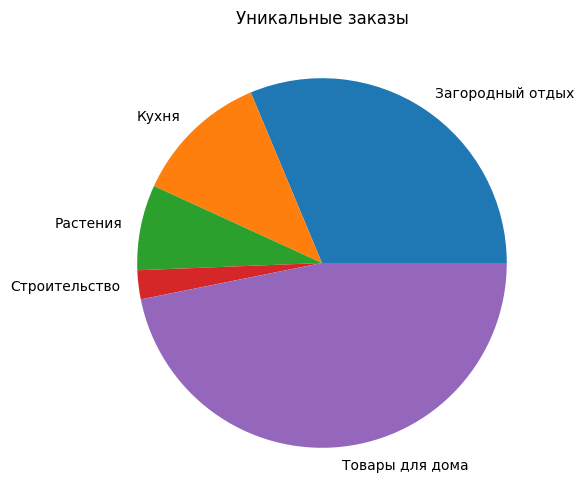

In [ ]:
by_categ = ndf.groupby('category')[['order_id']].nunique()
plt.figure(figsize = (6, 6))
plt.pie(by_categ['order_id'], labels=by_categ.index)
plt.title('Уникальные заказы')
plt.show()

Чаще всего заказывают товары для дома и товары для загородного отдыха(отчасти потому что их большинство, среди сегментируемых)
Затем идут кухонные товары, растения и товары связанные со строительством.

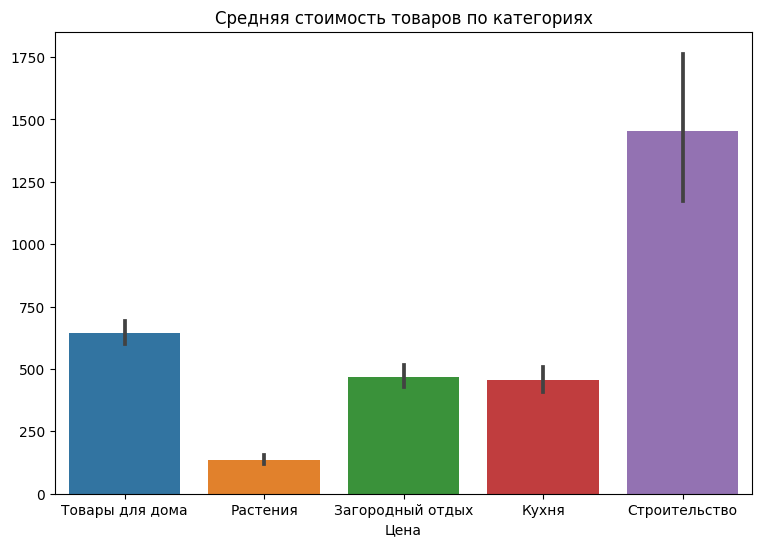

In [ ]:
plt.figure(figsize=(9, 6))
sns.barplot(data=ndf, y='price', x='category')
plt.xlabel('Цена')
plt.ylabel('')
plt.title('Средняя стоимость товаров по категориях')
plt.show()

Наибольший разброс цен заметен в категории товаров для строительства
Самыми доступными являются товары категории Растения.

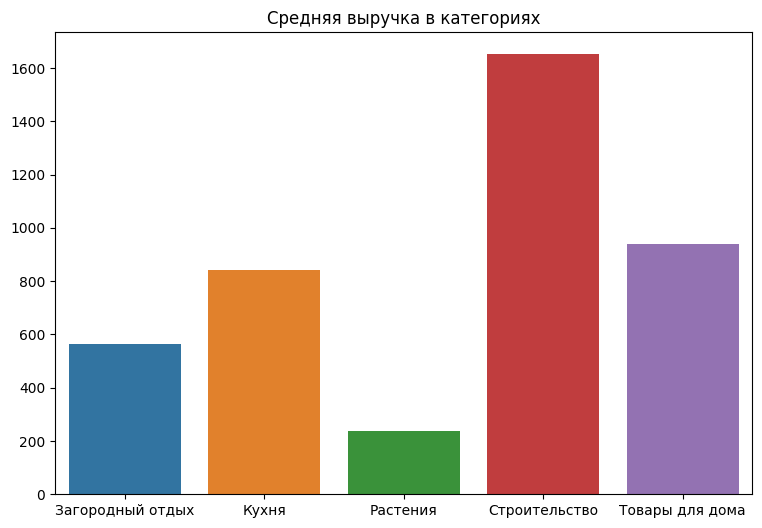

In [ ]:
revenue_by_category = ndf.groupby('category').agg({'revenue':'mean'}).reset_index()
plt.figure(figsize=(9, 6))
sns.barplot(data=revenue_by_category, y='revenue', x='category')
plt.xlabel('')
plt.ylabel('')
plt.title('Средняя выручка в категориях')
plt.show()

Самой прибыльной по выручке является категория Строительство
За ним идет Кухня и Товары для дома

In [ ]:
ndf['month'] = ndf['date'].dt.month
def get_season(x):
    if x in [1,2,12]:
        return 'winter'
    if x in [3,4,5]:
        return 'spring'
    if x in [6,7,8]:
        return 'summer'
    if x in [9,10,11]:
        return 'autumn'

In [ ]:
ndf['season'] = ndf['month'].apply(get_season)

In [ ]:
ndf.groupby('season').agg({'order_id':'count'})

,order_id
season,
autumn,1352
spring,1832
summer,821
winter,867


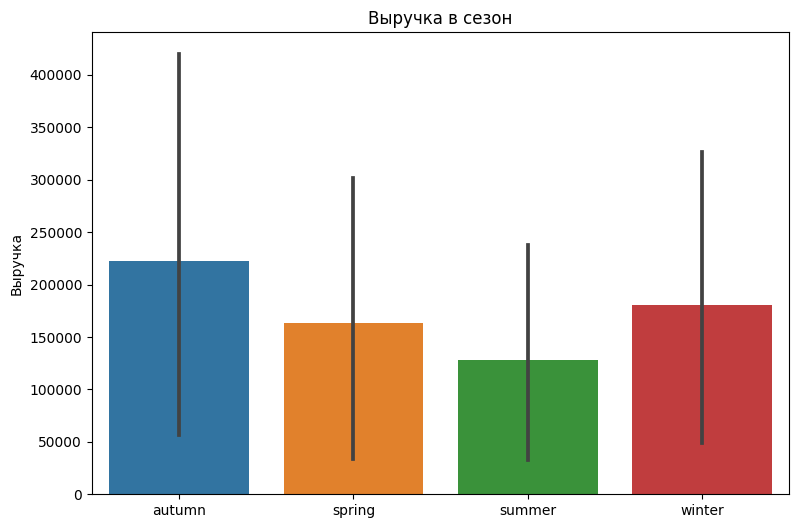

In [ ]:
rev_by_season = ndf.groupby(['season','category']).agg({'revenue':'sum'}).reset_index()

plt.figure(figsize=(9, 6))
sns.barplot(data=rev_by_season, y='revenue', x='season')
plt.xlabel('')
plt.ylabel('Выручка')
plt.title('Выручка в сезон')
plt.show()

Наиболее объемным сезоном можно называть Осень и Зиму.Летом и весной продажии заметно ниже

In [ ]:
fig = px.sunburst(rev_by_season,
                  path=["season", "category"],
                  values='revenue',
                  title="Распределение по сезонам, с делением категориям ",
                  width=650, height=650)
fig.show()

Топ 2 категории в любой сезон - Товары для отдыха и Загородный отдых. Летом заметно возрастают продажи категории Растения. Так же Осенью заметно возрастают продажи категории строительство.

In [ ]:
revenue_by_mean_category = ndf.groupby(['mean_score' , 'category']).agg({'revenue':'mean'}).reset_index()

fig = px.sunburst(revenue_by_mean_category,
                  path=["mean_score", "category"],
                  values='revenue',
                  title="Распределение по кластерам, с разбивкой по категориям товара. ",
                  width=650, height=650)
fig.show()

In [ ]:
revenue_by_mean_category = ndf.groupby(['mean_score' , 'category']).agg({'revenue':'sum'}).reset_index()

fig = px.sunburst(revenue_by_mean_category,
                  path=["mean_score", "category"],
                  values='revenue',
                  title="Распределение по кластерам, с разбивкой по категориям товара. ",
                  width=650, height=650)
fig.show()

In [ ]:
revenue_by_mean_category.style.background_gradient(subset='revenue', cmap='Blues')

,mean_score,category,revenue
0,1.000000,Загородный отдых,25748.000000
1,1.000000,Кухня,18027.000000
2,1.000000,Растения,8995.000000
3,1.000000,Строительство,1582.000000
4,1.000000,Товары для дома,62706.000000
5,2.000000,Загородный отдых,572008.000000
6,2.000000,Кухня,227435.000000
7,2.000000,Растения,60791.000000
8,2.000000,Строительство,62076.000000
9,2.000000,Товары для дома,812392.000000


Для 2,3,4 классетра самыми прибыльными считаются товары из категории строительство и товары для дома.

In [ ]:

fig = px.bar(revenue_by_mean_category, x='mean_score', y='revenue',color = 'category')
fig.update_traces(textposition='outside')
fig.update_layout(
    title='Распределение выручки по кластерам и категориям',
    xaxis_title="Группа",
    yaxis_title="Выручка")

fig.show()

# Вывод
Для сегментации товаров на категории мы привели названия товаров к лемме и отсортировали по наличию ключевых слов в 5 категорий: Загородный отдых , Товары для дома, Растения ,Кухня, Строительство. Группы товаров получились несоразмерными, тем не менее это позволяет выделить следующие закономерности:
Чаще всего заказывают товары для дома и товары для загородного отдыха(отчасти потому что их большинство, среди сегментируемых)
Затем идут кухонные товары, растения и товары связанные со строительством.
Наибольший разброс цен заметен в категории товаров для строительства
Самыми доступными являются товары категории Растения.
Самой прибыльной по выручке является категория Строительство
За ним идет Кухня и Товары для дома.
Топ 2 категории в любой сезон - Товары для отдыха и Загородный отдых. Летом заметно возрастают  продажи категории Растения. Так же Осенью заметно возрастают продажи категории строительство.

### Формулировка и проверка гипотез
Гипотезы которые я буду проверять:
- H0 - Между выручкой разных кластеров нет статистически значимой разницы.
- H1 - Между выручкой разных кластеров есть статистически значимая разница.
__________________________________________________________________
- H0 - Между кол-вом в заказе в разных кластерах нет статистически значимой разницы.
- H1 - Между кол-вом в заказе в разных кластерах есть статистически значимая разница.
__________________________________________________________________

Для теста будем использовать U-тест Манна-Уитни - в данном случае наиболее простой и распространенный способ. Альфа = 0.05. Так как у нас идет множественная проверка - добавляем поправку Бонферрони к Альфе.


In [ ]:
# создаем простую функцию для проверки статистических гипотез
def get_ttest(q1,q2,metric):
  alpha = 0.05 / 6
  results = stats.mannwhitneyu(ndf.query('mean_score == @q1')[metric], ndf.query('mean_score == @q2')[metric])
  print('Сравнение', q1, 'и ', q2,'группы. Метрика: ' ,metric)
  print('p-значение: ', results.pvalue)
  if results.pvalue < alpha:
      print('Отвергаем нулевую гипотезу: между выборками есть значимая разница')
  else:
      print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными')

In [ ]:
get_ttest(1,2,'revenue')
get_ttest(1,3,'revenue')
get_ttest(1,4,'revenue')
get_ttest(2,3,'revenue')
get_ttest(2,4,'revenue')
get_ttest(3,4,'revenue')


Сравнение 1 и  2 группы. Метрика:  revenue
p-значение:  4.724418743659989e-15
Отвергаем нулевую гипотезу: между выборками есть значимая разница
Сравнение 1 и  3 группы. Метрика:  revenue
p-значение:  2.1321907829121798e-16
Отвергаем нулевую гипотезу: между выборками есть значимая разница
Сравнение 1 и  4 группы. Метрика:  revenue
p-значение:  0.2502360326093245
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Сравнение 2 и  3 группы. Метрика:  revenue
p-значение:  0.0022051817478869994
Отвергаем нулевую гипотезу: между выборками есть значимая разница
Сравнение 2 и  4 группы. Метрика:  revenue
p-значение:  1.28057080083799e-05
Отвергаем нулевую гипотезу: между выборками есть значимая разница
Сравнение 3 и  4 группы. Метрика:  revenue
p-значение:  4.2305439082919317e-07
Отвергаем нулевую гипотезу: между выборками есть значимая разница


Тесты по всем группам показали значительную разницу, за исключением одной : 1 и 4 группа не имеют значительной разницы, по ним мы не можем отвергнуть нулевую гипотезу.

In [ ]:
get_ttest(1,2,'quantity')
get_ttest(1,3,'quantity')
get_ttest(1,4,'quantity')
get_ttest(2,3,'quantity')
get_ttest(2,4,'quantity')
get_ttest(3,4,'quantity')

Сравнение 1 и  2 группы. Метрика:  quantity
p-значение:  0.7376948463105615
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Сравнение 1 и  3 группы. Метрика:  quantity
p-значение:  0.19196798321245634
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Сравнение 1 и  4 группы. Метрика:  quantity
p-значение:  0.7497100232879899
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Сравнение 2 и  3 группы. Метрика:  quantity
p-значение:  0.011966981116202815
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Сравнение 2 и  4 группы. Метрика:  quantity
p-значение:  0.518036733444516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными
Сравнение 3 и  4 группы. Метрика:  quantity
p-значение:  0.38544800053776973
Не получилось отвергнуть нулевую гипотезу, нет оснований считать выборки разными


Тесты по всем группам  не показали значительную разницу, мы не можем отвергать нулевую гипотезу.

# Итоговый вывод
Нами был проанализирован df с транзакциями интернет-магазина товаров для дома и быта «Пока все ещё тут».
В исходном файле представлена информация о 6737 транзакциях пользователей, в разбивке по дате, пользователю, заказу, продукту, кол-ву, цене. Исследуемый период 2018-10-01 по 2019-10-31.
Можно говорить о всплеске заказов в период с мая 2019 - до июля 2019 - вероятнее всего есть сезонность в покупках.На графике уникальных пользователей видно, что всплески активности происходят неравномерно. Больше всего пиков мы видим с Апреля 2019 - до Мая 2019 .Для сегментации пользователей мы применили RFM анализ, который позволяет оценить: на сколько давно пользователь совершил покупку? как часто покупал до этого? как много потратил пользователь?
Анализ позволил сегментировать пользователей на группы, в зависимости от их ценности. Чем больше число - тем ценнее пользователь.
RFM анализ позволил сделать следующие выводы:
- Показатели всех трех кластеров показывают примерно похожие результаты, тем не менее 3 и 4 кастер заметно выделяются.
- По кумулятивной выручке лидирует кластер 2 , за ним идет 3.
- Кластеры 1 имеет самый низкий показатель куммулятивной выручке.

Мы так же провели сегментацию товаров на категории: Загородный отдых , Товары для дома, Растения ,Кухня, Строительство. Группы товаров получились несоразмерными, тем не менее это позволяет выделить следующие закономерности:
- Чаще всего заказывают товары для дома и товары для загородного отдыха(отчасти потому что их большинство, среди сегментируемых)
- Затем идут кухонные товары, растения и товары связанные со строительством.
- Наибольший разброс цен заметен в категории товаров для строительства
- Самой прибыльной по выручке является категория Строительство.
За ним идет Кухня и Товары для дома.


### Профили и рекомендации для каждого кластера:

- Кластер 1 :
- Имеет самые низкие показатели выручки, среди остальных кластеров. По графику кумулятивной выручки - это потерянные клиенты
- Выручка по категориями у таких клиентов однородна,на уровне 200-250 у.е., никакая из категорий не выделяется на фоне остальных
- Таких клиентов необходимо вернуть, и привлекать на категории с высокой выручкой:Строительство, Кухня, Товары для дома
- Проработать обратную связь от клиентов (особенно для группы RFM score 111) - такие покупатели уже знакомы с нашим магазином, но им мог не понравится сервис или они не нашли того, что искали.

- Кластер 2:
- Второй кластер один из наиболее многочисленных (2596 покупателей) и оборотистых, среди остальных - это покупатели, которые формируют основную часть выручки.
- Покупатели из кластера 2 больше тратят на товары категории Строительство и Кухня (1500 и 850 у.е.)
- Чтобы по таким покупателям повышать уровень выручки их стоит привлекать их наиболее оборотистыми категориями, например Строительство
- Проведение акций, для лояльных клиентов, направленных на увеличение среднего чека позволит компании значительно увеличить выручку в целом. Подойдут как ценовые промо на категории товаров, так и карты лояльности с накопительной системой.
- Этот кластер стоит привлекать перед сезоном (мая-сентябрь), рассылками и предложении из категорий Загородный отдых

- Кластер 3:
- Одна из многочисленных групп наших покупателей (1366), их поведение и траты схожи с кластером 2 в предпочтениях по категориям и средним тратам
- Кластер имеет высокий уровень среднего чека в категории Строительство (2179 у.е.) и Товары для дома(1579 у.е.)
- Таких потребителей стоит привлекать на категорию товаров Кухня и Строительство, так как эти категории занимают слишком малый процент от общих трат. Подойдут ценовые промо.
- Этот кластер стоит привлекать перед сезоном (мая-сентябрь), рассылками и предложеними из категорий Загородный отдых

- Кластер 4:
- Наиболее лояльные наши клиенты, при этом не самым многочисленные (403). Мы стремимся, чтобы таких клиентов становилось больше
- Стоит сделать акцент на категории Кухни или Строительство, расширить ассортимент, добавить товары соответствующего ценового сегмента( В 4 кластере покупатели тратят в два раза меньше, чем покупатели 3 кластера)
- Кластер 4 имеет самые низкие (по сравнению с 2 и 3 кластером) обороты по категории Загородный отдых - это сезонная категория, стоит включить таких потребителей в рассылки перед сезоном (мая-сентябрь)
- Сделать акцент на категории Товары для дома - это категория является наиболее продаваемой в нашем ассортименте, при этом в среднем покупатели из 4 кластера тратят меньше, чем из кластера 3.